# Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

In [5]:
df = pd.read_csv("waze_dataset.csv")
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


### Dataset Label Context

> label - Binary target variable (“retained” vs “churned”) for if a user has churned anytime during the course of the month 

> sessions - The number of occurrence of a user opening the app during the month

> drives - An occurrence of driving at least 1 km during the month

> device - The type of device a user starts a session with

> total_sessions - A model estimate of the total number of sessions since a user has onboarded

> n_days_after_onboarding - The number of days since a user signed up for the app

> total_navigations_fav1 - Total navigations since onboarding to the user’s favorite place 1

> total_navigations_fav2 - Total navigations since onboarding to the user’s favorite place 2

> driven_km_drives - Total kilometers driven during the month

> duration_minutes_drives - Total duration driven in minutes during the month

> activity_days - Number of days the user opens the app during the month 

> driving_days - Number of days the user drives (at least 1 km) during the month

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


Column 'Label' has 700 missing value count

In [7]:
df.device.nunique()

2

2 Unique number of devices -> Iphone and Android Categories

In [8]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


In [9]:
# Dataframe containing the 'Not Available' data 
df[df['label'].isna()].describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,7405.584286,80.837143,67.798571,198.483348,1709.295714,118.717143,30.371429,3935.967029,1795.123358,15.382857,12.125714
std,4306.900234,79.987440,65.271926,140.561715,1005.306562,156.308140,46.306984,2443.107121,1419.242246,8.772714,7.626373
min,77.000000,0.000000,0.000000,5.582648,16.000000,0.000000,0.000000,290.119811,66.588493,0.000000,0.000000
25%,3744.500000,23.000000,20.000000,94.056340,869.000000,4.000000,0.000000,2119.344818,779.009271,8.000000,6.000000
50%,7443.000000,56.000000,47.500000,177.255925,1650.500000,62.500000,10.000000,3421.156721,1414.966279,15.000000,12.000000
75%,11007.000000,112.250000,94.000000,266.058022,2508.750000,169.250000,43.000000,5166.097373,2443.955404,23.000000,18.000000
max,14993.000000,556.000000,445.000000,1076.879741,3498.000000,1096.000000,352.000000,15135.391280,9746.253023,31.000000,30.000000


In [10]:
df[~df['label'].isna()].describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


Checkuing for the Churned vs Retained

In [11]:
print("Churned vs retained count")
print(df['label'].value_counts())

print()

print("Churned vs Retained percentage in the dataset")
print(df['label'].value_counts(normalize = True)*100)

Churned vs retained count
retained    11763
churned      2536
Name: label, dtype: int64

Churned vs Retained percentage in the dataset
retained    82.264494
churned     17.735506
Name: label, dtype: float64


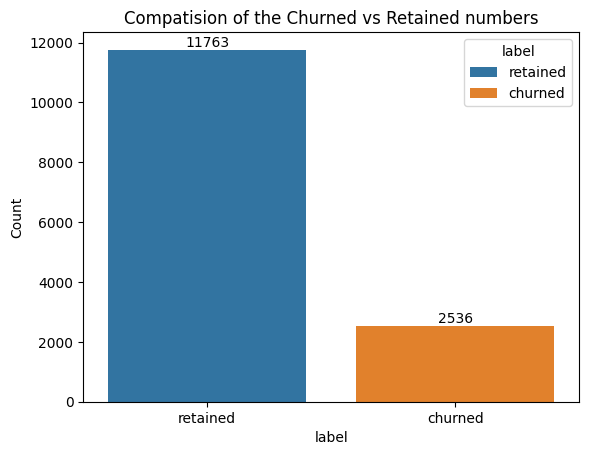

In [12]:
plot = sns.countplot(data = df, x = 'label', hue = 'label')
for bars in plot.containers:
    plot.bar_label(bars)

plt.title("Compatision of the Churned vs Retained numbers")
plt.ylabel('Count')
plt.show()

For the following we are calculaing the medians for each device types . The reason for calculating median is that the presence of outliers are most likely to deflect the present mean off the course

In [13]:
df.groupby('label',as_index=False).median(numeric_only=True)

,label,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,churned,7477.5,59.0,50.0,164.339042,1321.0,84.5,11.0,3652.655666,1607.183785,8.0,6.0
1,retained,7509.0,56.0,47.0,157.586756,1843.0,68.0,9.0,3464.684614,1458.046141,17.0,14.0


This offers an interesting snapshot of the two groups, churned vs. retained: <br>
Users who churned averaged ~3 more drives in the last month than retained users, but retained users used the app on over twice as many days as churned users in the same time period. <br>
The median churned user drove ~200 more kilometers and 2.5 more hours during the last month than the median retained user. <br>
It seems that churned users had more drives in fewer days, and their trips were farther and longer in duration. Perhaps this is suggestive of a user profile. 


In [14]:
# Calculating the median kilometers per drive in the last month for both retained and churned users
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
# grouping the data with respect to label
df.groupby('label',as_index=False)['km_per_drive'].median()

,label,km_per_drive
0,churned,74.109416
1,retained,75.014702


Median Retained users tends to drive a kilometer more than the churned users

In [16]:
# Now calculating km driven per day of the recent month
df['km_per_driving _day'] = df['driven_km_drives'] / df['driving_days']
df.groupby('label',as_index = False)['km_per_driving _day'].median()

,label,km_per_driving _day
0,churned,697.541999
1,retained,289.549333


In [17]:
# Calculating the number of drives per driving day (day with atleast more than 1km drive recorded on app)
df['drives_per_driving_day'] = df['drives'] / df['driving_days']

df.groupby('label')[['drives_per_driving_day']].median()

,drives_per_driving_day
label,
churned,10.0000
retained,4.0625


In [18]:
print(f"ratio churned to retained user for drives_per_driving_day : {10/4.0625}")
print()
print(f"ratio churned to retained user for km_per_driving_day : {697.541999/289.549333}")

ratio churned to retained user for drives_per_driving_day : 2.4615384615384617

ratio churned to retained user for km_per_driving_day : 2.40906097683879


> Summary

1. The median user who churned drove 698 kilometers each day in their last month, which is almost ~2.4 times the per-drive-day distance of retained users. The median churned user had a similar ratio number of drives per drive day compared to retained users. <br>
2. It is clear from these figures that, regardless of whether a user churned or not, the users represented in this data are serious drivers! From a little reserach , any typical daily driver drives around 60 km (apprx) on an average. This genreal statistic is way less than to the one in the dataset we have. <br> 
3. It would probably be safe to assume that this data does not represent typical drivers at large. Perhaps the data ,and in particular the sample of churned users, contains a high proportion of long-haul truckers. <br>
In consideration of how much these users drive, it would be worthwhile to recommend to Waze that they gather more data on these super-drivers. It's possible that the reason for their driving so much is also the reason why the Waze app does not meet their specific set of needs.


Now jumping on to see whether the device type has any correlation to the label column

In [23]:
df.groupby('label',as_index=True)['device'].value_counts(normalize = True)*100

label     device 
churned   iPhone     64.865931
          Android    35.134069
retained  iPhone     64.439344
          Android    35.560656
Name: device, dtype: float64

The ratio of iPhone users and Android users is consistent between the churned group and the retained group

## 2. Exploratory Data Analysis (EDA)

In [25]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_drive,km_per_driving _day,drives_per_driving_day
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,11.632058,138.360267,11.894737
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,128.186173,1246.901868,9.727273
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,32.201567,382.393602,11.875000
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,22.839778,304.530374,13.333333
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,58.091206,219.455667,3.777778


##### sessions : The number of occurrence of a user opening the app during the month

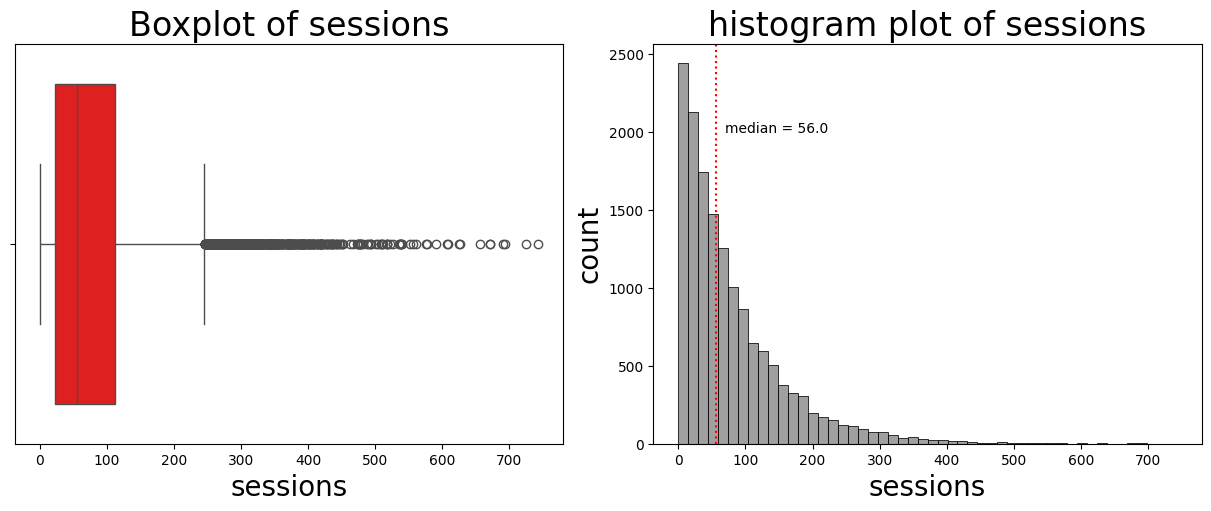

In [62]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot for the sessions
sns.boxplot(data = df, x = 'sessions', color = 'r', ax = axes[0])
axes[0].set_xlabel("sessions",fontsize = 20)
axes[0].set_title('Boxplot of sessions', fontsize=24)

#histogram plot
median_of_sessions = np.median(df['sessions'])
sns.histplot(data = df, x='sessions',bins =50,color='grey')
axes[1].axvline(median_of_sessions,color='red',ls=":",label='Median')
axes[1].set_title('histogram plot of sessions', fontsize=24)
axes[1].set_xlabel('sessions',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(70,2000,'median = 56.0')

plt.show()

*sessions* column is as a right skewed data , having a median of 56, meaning 50% of the values are lower than 56 sessions in the last month

##### total_sessions - A model estimate of the total number of sessions since a user has onboarded

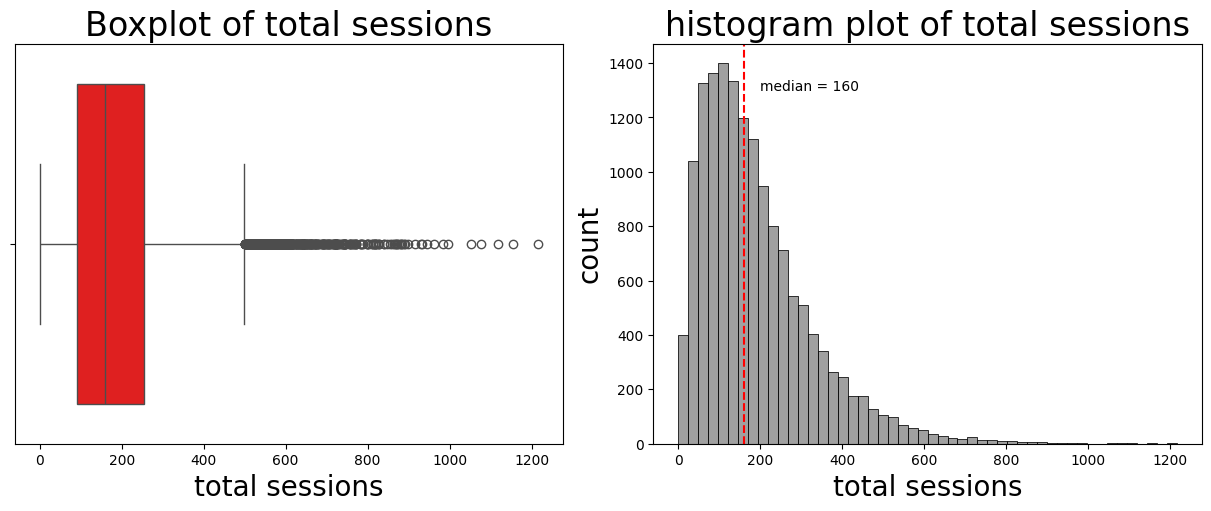

In [69]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot for the total_sessions
sns.boxplot(data = df, x = 'total_sessions', color = 'r', ax = axes[0])
axes[0].set_xlabel("total sessions",fontsize = 20)
axes[0].set_title('Boxplot of total sessions', fontsize=24)

#histogram plot
median_of_total_sessions = np.median(df['total_sessions'])
sns.histplot(data = df, x='total_sessions',bins =50,color='grey')
axes[1].axvline(median_of_total_sessions,color='red',ls="--",label='Median')
axes[1].set_title('histogram plot of total sessions', fontsize=24)
axes[1].set_xlabel('total sessions',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(200,1300,'median = 160')

plt.show()

The distribution for the label *total_session* is also right skewed, having the median as 160 (apprx).
Here we can observe an interesting point, This column has the session counts since the user registered that is 160 and the median session count for the last month is 56 accounting for the 35% usage of the app in the recent month.

##### drives - An occurrence of driving at least 1 km during the month

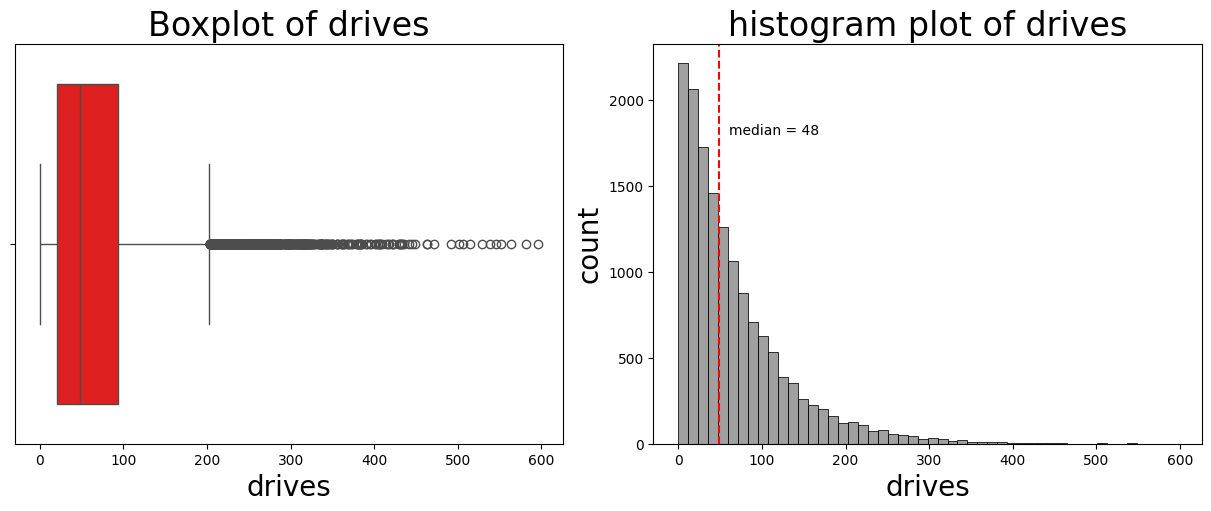

In [76]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot 
sns.boxplot(data = df, x = 'drives', color = 'r', ax = axes[0])
axes[0].set_xlabel("drives",fontsize = 20)
axes[0].set_title('Boxplot of drives', fontsize=24)

#histogram plot
median_of_drives = np.median(df['drives'])
sns.histplot(data = df, x='drives',bins =50,color='grey')
axes[1].axvline(median_of_drives,color='red',ls="--",label='Median')
axes[1].set_title('histogram plot of drives', fontsize=24)
axes[1].set_xlabel('drives',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(60,1800,'median = 48')

plt.show()

As expected, the distribution is similar to that of the session , medians are quite close (49,56), suggesting direct correlation between the 2 labels 

##### n_days_after_onboarding -The number of days since a user signed up for the app.

Text(1800, 650, 'median = 1741')

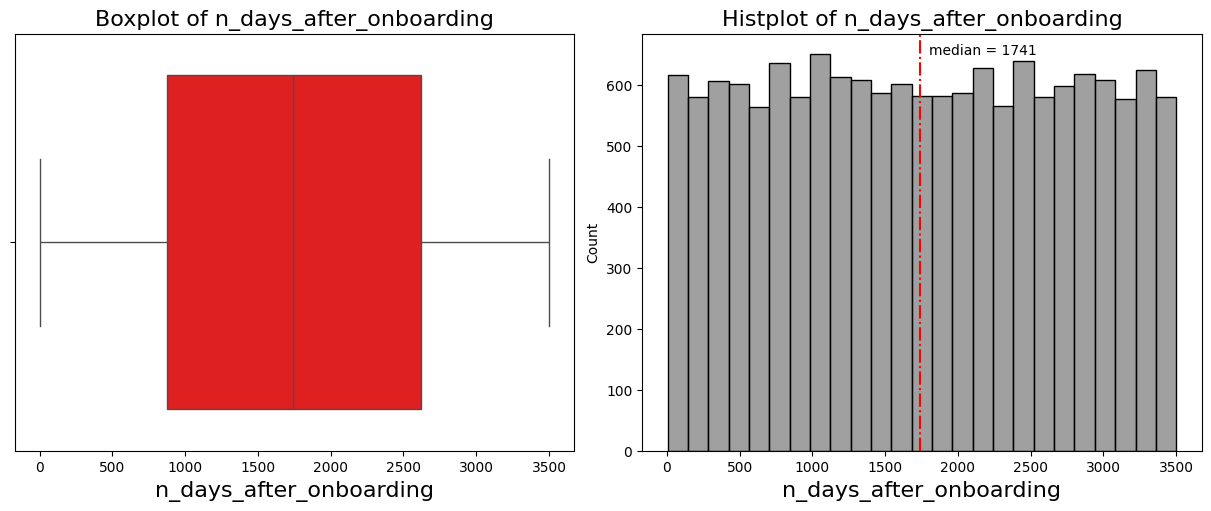

In [86]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(12,5),constrained_layout=True)

sns.boxplot(data=df,x='n_days_after_onboarding',color='r',ax=axes[0])
axes[0].set_xlabel('n_days_after_onboarding',fontsize=16)
axes[0].set_title("Boxplot of n_days_after_onboarding",fontsize=16)

median_onboarding = np.median(df['n_days_after_onboarding'])
sns.histplot(data=df,x='n_days_after_onboarding',color='grey')
axes[1].set_title("Histplot of n_days_after_onboarding",fontsize=16)
axes[1].axvline(median_onboarding,ls="-.",color='red')
axes[1].set_xlabel("n_days_after_onboarding",fontsize=16)
axes[1].text(1800,650,"median = 1741")

This distribution is quite uniform across all of the range , ranging from 0 to approximately 9.5 yeards of onboarding time on the app across various users

##### driven_km_drives.- Total kilometers driven during the month.

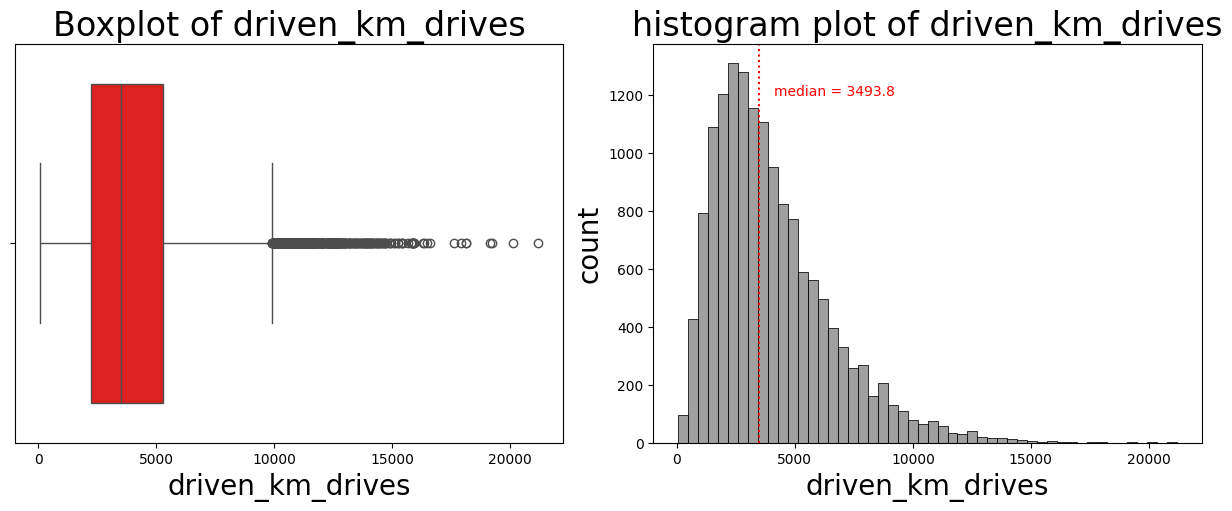

In [90]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot 
sns.boxplot(data = df, x = 'driven_km_drives', color = 'r', ax = axes[0])
axes[0].set_xlabel("driven_km_drives",fontsize = 20)
axes[0].set_title('Boxplot of driven_km_drives', fontsize=24)

#histogram plot
median_total_km_driven = np.median(df['driven_km_drives'])
sns.histplot(data = df, x='driven_km_drives',bins =50,color='grey')
axes[1].axvline(median_total_km_driven,color='red',ls=":",label='Median')
axes[1].set_title('histogram plot of driven_km_drives', fontsize=24)
axes[1].set_xlabel('driven_km_drives',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(4100,1200,'median = 3493.8',color='red')

plt.show()

The distribution for the total km driven in the past month is right skewed and has a median of approximately 3500 kilometers, Meaning there are atleast 50% of people who are driving more then 100km per day (even after considering theu drive everysingle day)

##### duration_minutes_drives - Total duration driven (in minutes) during the month.

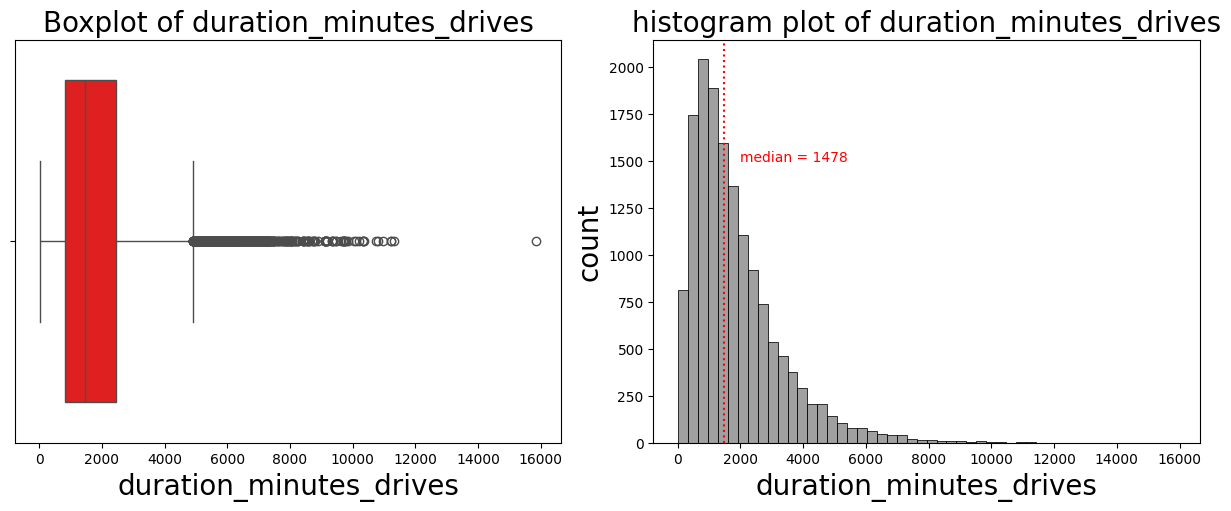

In [99]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot 
sns.boxplot(data = df, x = 'duration_minutes_drives', color = 'r', ax = axes[0])
axes[0].set_xlabel("duration_minutes_drives",fontsize = 20)
axes[0].set_title('Boxplot of duration_minutes_drives', fontsize=20)

#histogram plot
median_duration_minute_drive = np.median(df['duration_minutes_drives'])
sns.histplot(data = df, x='duration_minutes_drives',bins =50,color='grey')
axes[1].axvline(median_duration_minute_drive,color='red',ls=":",label='Median')
axes[1].set_title('histogram plot of duration_minutes_drives', fontsize=20)
axes[1].set_xlabel('duration_minutes_drives',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(2000,1500,'median = 1478',color='red')

plt.show()

The duration_minutes_drives variable has a heavily skewed right tail. Half of the users drove less than 1500 minutes (~25 hours).

##### activity_days - Number of days the user opens the app during the month.

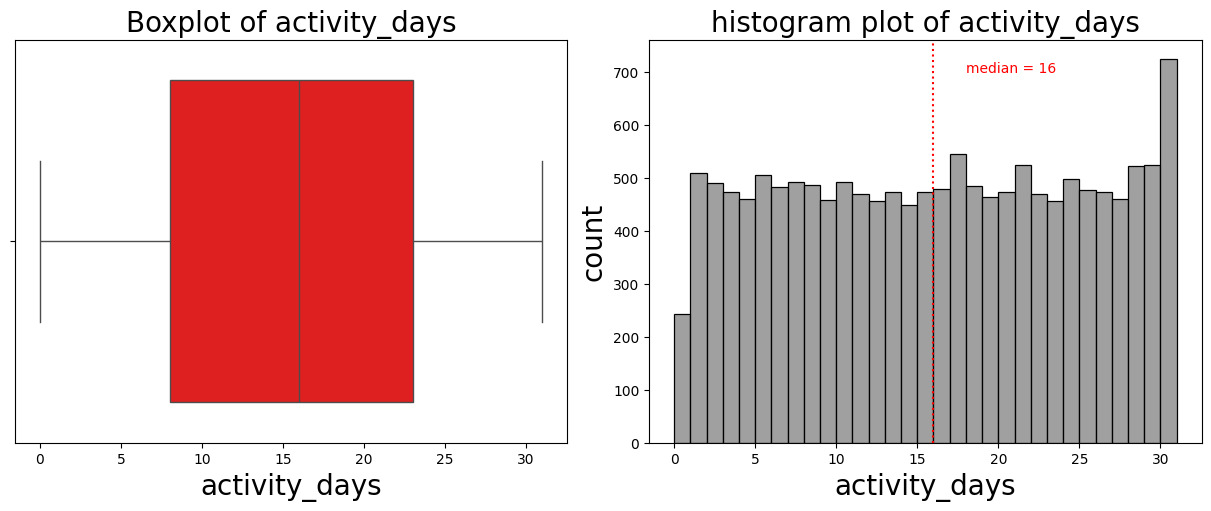

In [109]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot 
sns.boxplot(data = df, x = 'activity_days', color = 'r', ax = axes[0])
axes[0].set_xlabel("activity_days",fontsize = 20)
axes[0].set_title('Boxplot of activity_days', fontsize=20)

#histogram plot
median_activity_days = np.median(df['activity_days'])
sns.histplot(data = df, x='activity_days',bins =31,color='grey')
axes[1].axvline(median_activity_days,color='red',ls=":",label='Median')
axes[1].set_title('histogram plot of activity_days', fontsize=20)
axes[1].set_xlabel('activity_days',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(18,700,'median = 16',color='red')

plt.show()

In [100]:
np.median(df['activity_days'])

16.0

In [11]:
df_churn = df[df['label'] == 'churned']
df_churn.head(20)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone
14,14,churned,72,66,401.351809,2524,54,24,5922.811202,2227.280393,0,0,Android
17,17,churned,272,219,564.271485,88,0,90,3529.338980,2078.426838,11,11,Android
22,22,churned,73,60,118.808812,1607,254,92,2653.436921,400.707310,16,16,iPhone
23,23,churned,29,23,33.137029,2188,338,0,4283.503913,654.519007,2,2,iPhone
27,27,churned,5,5,215.876461,2465,412,0,925.030474,490.534675,16,8,iPhone
46,46,churned,114,105,309.582855,189,11,7,4285.245618,2322.605058,9,4,iPhone
47,47,churned,23,20,24.758514,552,65,14,1564.220191,821.842088,3,3,iPhone
48,48,churned,48,42,223.252729,757,335,28,9947.593149,3369.145354,8,2,iPhone
56,56,churned,150,127,187.708346,2028,208,132,1396.461977,496.620891,0,0,iPhone


In [13]:
df_retained = df[df['label'] == 'retained']
df_retained.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android
10,10,retained,23,20,117.225772,1946,0,36,8554.914440,5352.567720,9,9,iPhone


In [15]:
df_churn.shape

(2536, 13)

In [17]:
df_churn.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000
mean,7544.852918,87.238959,72.730678,196.893424,1471.027603,139.414826,31.596609,4147.171864,1975.459630,9.644716,7.218060
std,4401.273381,88.401217,72.082117,140.985386,985.980038,164.007095,48.919135,2499.577849,1465.960239,7.706983,6.543208
min,9.000000,0.000000,0.000000,1.362129,6.000000,0.000000,0.000000,178.232313,23.022685,0.000000,0.000000
25%,3691.250000,25.000000,22.000000,93.496698,626.000000,14.750000,0.000000,2304.118861,928.668633,3.000000,2.000000
50%,7477.500000,59.000000,50.000000,164.339042,1321.000000,84.500000,11.000000,3652.655666,1607.183785,8.000000,6.000000
75%,11364.500000,120.000000,100.000000,265.362864,2238.500000,201.000000,46.000000,5381.361396,2622.819187,14.000000,11.000000
max,14997.000000,743.000000,596.000000,1216.154633,3496.000000,1170.000000,396.000000,19214.475110,10040.568960,31.000000,29.000000


C:\Users\arins\AppData\Local\Temp\ipykernel_5260\1180660614.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_churn.corr(),annot=True,fmt=".2f", cmap='coolwarm', ax=axes[0])
C:\Users\arins\AppData\Local\Temp\ipykernel_5260\1180660614.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_retained.corr(),annot = True,fmt=".2f", cmap='coolwarm', ax=axes[1])


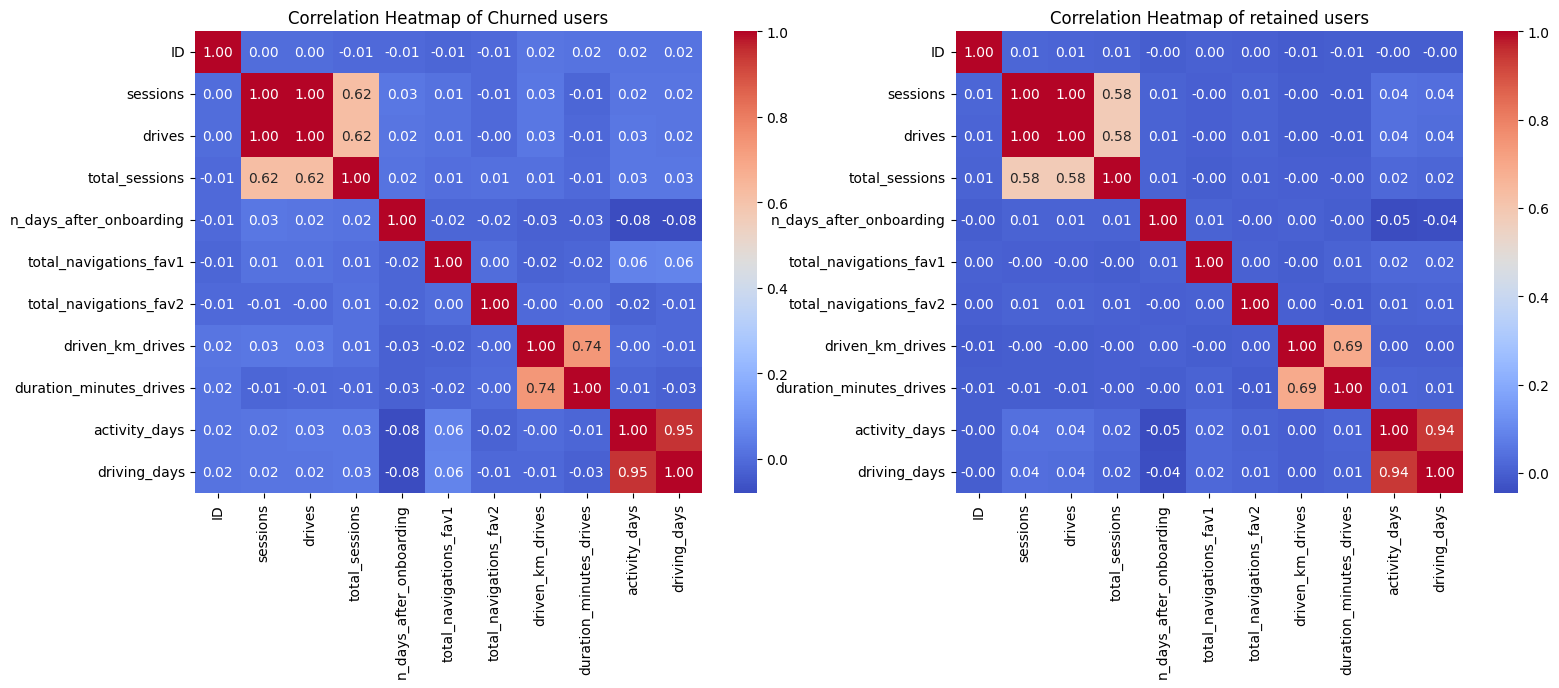

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.heatmap(df_churn.corr(),annot=True,fmt=".2f", cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Heatmap of Churned users')

sns.heatmap(df_retained.corr(),annot = True,fmt=".2f", cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Heatmap of retained users')

plt.show()

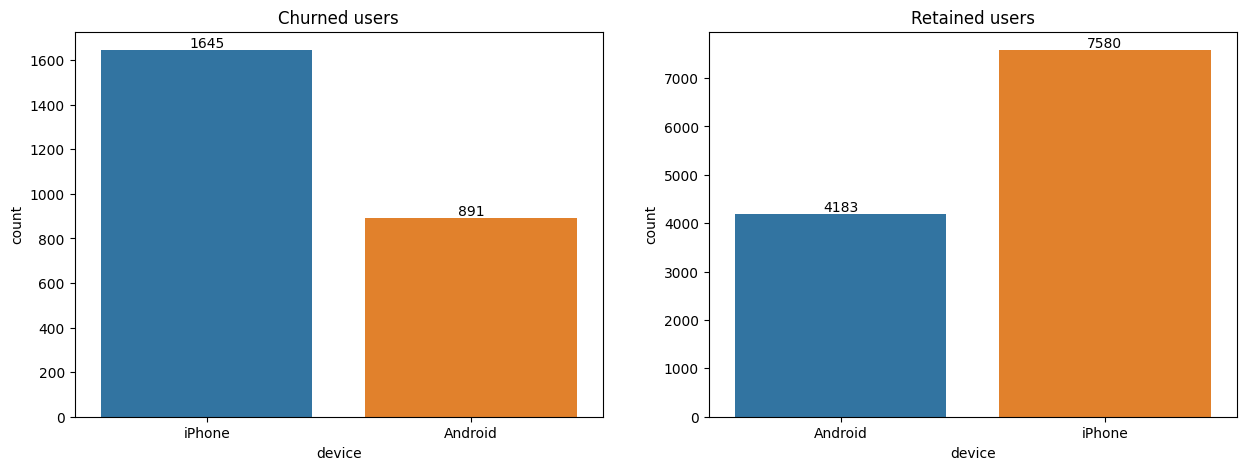

In [39]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

plot1 = sns.countplot(data = df_churn,x='device',hue = 'device', ax =axes[0])
for bars in plot1.containers:
    plot1.bar_label(bars)
axes[0].set_title("Churned users")

plot2 = sns.countplot(data = df_retained,x='device',hue = 'device', ax =axes[1])
for bars in plot2.containers:
    plot2.bar_label(bars)
axes[1].set_title("Retained users")

plt.show()

In [43]:
df.columns

Index(['ID', 'label', 'sessions', 'drives', 'total_sessions',
       'n_days_after_onboarding', 'total_navigations_fav1',
       'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives',
       'activity_days', 'driving_days', 'device'],
      dtype='object')

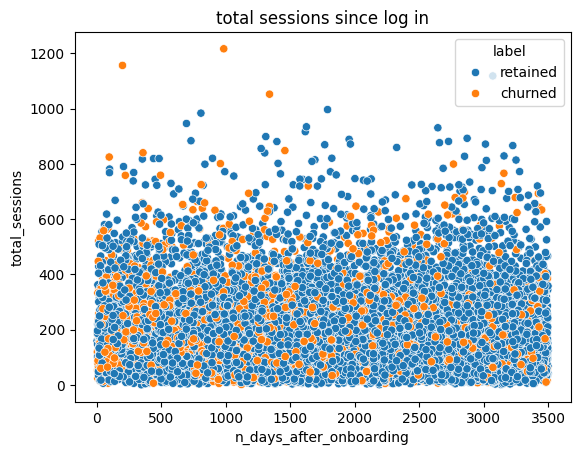

In [44]:
sns.scatterplot(data = df, x = 'n_days_after_onboarding', y = 'total_sessions', hue = 'label')
plt.title("total sessions since log in")
plt.show()